### Library Imports


In [3]:
!pip install xgboost

#import sys
#!conda install --yes --prefix {sys.prefix} -c conda-forge lightgbm

In [1]:
# Data manipulation
import pandas as pd 
import numpy as np

# GeoData manipulation
import Geohash
import geopandas as gpd
from shapely.geometry import Point

# Plotting Data
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


### Data Reading and Manipulation

Motivation:
1. Since our test data will be unseen, all we know is that the geohashes are what we've seen before, and it lasts for 5 timestamps. Let us one-hot encode all the possible geohashes as indexes
2. Let us arrange our data in time-series fashion, with each feature corresponding to a timestamp


In [2]:
df = pd.read_csv('data/processed_data.csv')


In [3]:
# Get a one-hot encoding of all possible coordinates
# Sort geohashes in ascending order first
oneHot = pd.get_dummies(df.geohash6)
oneHot.head()
#df[(df['timestamp_float'] == time) & (df['day'] == day)]

# df = df.sort_values(['latitude', 'longitude'], ascending=[1, 1])
# df.tail()

,qp02yc,qp02yf,qp02yu,qp02yv,qp02yy,qp02yz,qp02z1,qp02z3,qp02z4,qp02z5,...,qp0djv,qp0djw,qp0djy,qp0dn0,qp0dn1,qp0dn4,qp0dn5,qp0dnh,qp0dnj,qp0dnn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
oneHot_transposed = oneHot.T
oneHot_transposed.head()

,0,1,2,3,4,5,6,7,8,9,...,4138000,4138001,4138002,4138003,4138004,4138005,4138006,4138007,4138008,4138009
qp02yc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
qp02yf,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
qp02yu,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
qp02yv,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
qp02yy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
columns = []
numDays = 61

# Create generator to yield column names
def drange(start, stop, step):
    r = start
    while r < stop:
        yield r
        r += step
         
# Create column names
for i in range(1, numDays + 1):
    for j in drange(0.00, 24, 0.25):
        columns.append((i,j))
        
# Delete columns at extra indexes
oneHot_transposed.drop(oneHot_transposed.iloc[:, len(columns)-1:-1], inplace = True, axis = 1) 

# Assign new column names
oneHot_transposed.columns = columns

In [6]:
oneHot_transposed.tail() 

,"(1, 0.0)","(1, 0.25)","(1, 0.5)","(1, 0.75)","(1, 1.0)","(1, 1.25)","(1, 1.5)","(1, 1.75)","(1, 2.0)","(1, 2.25)",...,"(61, 21.5)","(61, 21.75)","(61, 22.0)","(61, 22.25)","(61, 22.5)","(61, 22.75)","(61, 23.0)","(61, 23.25)","(61, 23.5)","(61, 23.75)"
qp0dn4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
qp0dn5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
qp0dnh,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
qp0dnj,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
qp0dnn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we have the data in our desired format, let us input the corresponding demand values into the right cells

In [8]:
#df_ToJoin = df.groupby(['day','timestamp_float'])
#df_ToJoin.head()
df_clean = df.drop(['timestamp', 'Coordinates_point', 'coordinates'], axis=1)
#df_ToJoin = df_clean.set_index(['day', 'timestamp_float']).sort_values(['day', 'timestamp_float'], ascending=[1, 1])
df_clean.head()

,geohash6,day,demand,latitude,longitude,timestamp_float
0,qp0djt,1,0.015854,-5.243225,90.950317,23.75
1,qp03te,1,0.001534,-5.342102,90.598755,23.75
2,qp09cs,1,0.006546,-5.292664,90.774536,23.75
3,qp0997,1,0.027050,-5.342102,90.763550,23.75
4,qp03xe,1,0.114208,-5.342102,90.686646,23.75


In [9]:
%%time

# Create list, then keep appending to it to form a list of lists
masterXList = []
masterYList = []
masterList = []
timeIndex = 0.0
dayIndex = 1
dataIndex = 0

oneHot_col = oneHot.columns.to_list()

while (dayIndex <= 61):
    timeIndex = 0
    while(timeIndex < 24): # to parse every timestamp possible   
        subList = [None]*len(oneHot.columns)
        subListX = [None]*len(oneHot.columns)
        subListY = [0]*len(oneHot.columns)
        df_short = df_clean[(df_clean.day == dayIndex) & (df_clean.timestamp_float == timeIndex)]
        for row in df_short.itertuples():        
            indexCol = oneHot_col.index(row.geohash6)
            elem = (row.day, row.timestamp_float, row.longitude, row.latitude, row.demand)
            elemX = (row.day, row.timestamp_float, row.longitude, row.latitude)
            elemY = row.demand
            
            subList[indexCol] = elem
            subListX[indexCol] = elemX
            subListY[indexCol] = elemY
            # Zero Imputation
            if(row.demand is None):
                elemY = 0
            #oneHot_transposed.at[indexCol,indexRow] = row.demand
        print("Time Done", timeIndex)
        timeIndex += 0.25
        masterXList.append(subListX)
        masterYList.append(subListY)
        masterList.append(subList)
    print("Day Done", dayIndex)
    dayIndex += 1
    
    
#     while(dataIndex < len(df)): # to parse every training row
#         for row in df_ToJoin.itertuples():
        
#         indexCol = oneHot_col.index(row.geohash6)

Time Done 0
Time Done 0.25
Time Done 0.5
Time Done 0.75
Time Done 1.0
Time Done 1.25
Time Done 1.5
Time Done 1.75
Time Done 2.0
Time Done 2.25
Time Done 2.5
Time Done 2.75
Time Done 3.0
Time Done 3.25
Time Done 3.5
Time Done 3.75
Time Done 4.0
Time Done 4.25
Time Done 4.5
Time Done 4.75
Time Done 5.0
Time Done 5.25
Time Done 5.5
Time Done 5.75
Time Done 6.0
Time Done 6.25
Time Done 6.5
Time Done 6.75
Time Done 7.0
Time Done 7.25
Time Done 7.5
Time Done 7.75
Time Done 8.0
Time Done 8.25
Time Done 8.5
Time Done 8.75
Time Done 9.0
Time Done 9.25
Time Done 9.5
Time Done 9.75
Time Done 10.0
Time Done 10.25
Time Done 10.5
Time Done 10.75
Time Done 11.0
Time Done 11.25
Time Done 11.5
Time Done 11.75
Time Done 12.0
Time Done 12.25
Time Done 12.5
Time Done 12.75
Time Done 13.0
Time Done 13.25
Time Done 13.5
Time Done 13.75
Time Done 14.0
Time Done 14.25
Time Done 14.5
Time Done 14.75
Time Done 15.0
Time Done 15.25
Time Done 15.5
Time Done 15.75
Time Done 16.0
Time Done 16.25
Time Done 16.5
Time

Time Done 15.5
Time Done 15.75
Time Done 16.0
Time Done 16.25
Time Done 16.5
Time Done 16.75
Time Done 17.0
Time Done 17.25
Time Done 17.5
Time Done 17.75
Time Done 18.0
Time Done 18.25
Time Done 18.5
Time Done 18.75
Time Done 19.0
Time Done 19.25
Time Done 19.5
Time Done 19.75
Time Done 20.0
Time Done 20.25
Time Done 20.5
Time Done 20.75
Time Done 21.0
Time Done 21.25
Time Done 21.5
Time Done 21.75
Time Done 22.0
Time Done 22.25
Time Done 22.5
Time Done 22.75
Time Done 23.0
Time Done 23.25
Time Done 23.5
Time Done 23.75
Day Done 6
Time Done 0
Time Done 0.25
Time Done 0.5
Time Done 0.75
Time Done 1.0
Time Done 1.25
Time Done 1.5
Time Done 1.75
Time Done 2.0
Time Done 2.25
Time Done 2.5
Time Done 2.75
Time Done 3.0
Time Done 3.25
Time Done 3.5
Time Done 3.75
Time Done 4.0
Time Done 4.25
Time Done 4.5
Time Done 4.75
Time Done 5.0
Time Done 5.25
Time Done 5.5
Time Done 5.75
Time Done 6.0
Time Done 6.25
Time Done 6.5
Time Done 6.75
Time Done 7.0
Time Done 7.25
Time Done 7.5
Time Done 7.75


Time Done 6.5
Time Done 6.75
Time Done 7.0
Time Done 7.25
Time Done 7.5
Time Done 7.75
Time Done 8.0
Time Done 8.25
Time Done 8.5
Time Done 8.75
Time Done 9.0
Time Done 9.25
Time Done 9.5
Time Done 9.75
Time Done 10.0
Time Done 10.25
Time Done 10.5
Time Done 10.75
Time Done 11.0
Time Done 11.25
Time Done 11.5
Time Done 11.75
Time Done 12.0
Time Done 12.25
Time Done 12.5
Time Done 12.75
Time Done 13.0
Time Done 13.25
Time Done 13.5
Time Done 13.75
Time Done 14.0
Time Done 14.25
Time Done 14.5
Time Done 14.75
Time Done 15.0
Time Done 15.25
Time Done 15.5
Time Done 15.75
Time Done 16.0
Time Done 16.25
Time Done 16.5
Time Done 16.75
Time Done 17.0
Time Done 17.25
Time Done 17.5
Time Done 17.75
Time Done 18.0
Time Done 18.25
Time Done 18.5
Time Done 18.75
Time Done 19.0
Time Done 19.25
Time Done 19.5
Time Done 19.75
Time Done 20.0
Time Done 20.25
Time Done 20.5
Time Done 20.75
Time Done 21.0
Time Done 21.25
Time Done 21.5
Time Done 21.75
Time Done 22.0
Time Done 22.25
Time Done 22.5
Time Do

Time Done 22.75
Time Done 23.0
Time Done 23.25
Time Done 23.5
Time Done 23.75
Day Done 17
Time Done 0
Time Done 0.25
Time Done 0.5
Time Done 0.75
Time Done 1.0
Time Done 1.25
Time Done 1.5
Time Done 1.75
Time Done 2.0
Time Done 2.25
Time Done 2.5
Time Done 2.75
Time Done 3.0
Time Done 3.25
Time Done 3.5
Time Done 3.75
Time Done 4.0
Time Done 4.25
Time Done 4.5
Time Done 4.75
Time Done 5.0
Time Done 5.25
Time Done 5.5
Time Done 5.75
Time Done 6.0
Time Done 6.25
Time Done 6.5
Time Done 6.75
Time Done 7.0
Time Done 7.25
Time Done 7.5
Time Done 7.75
Time Done 8.0
Time Done 8.25
Time Done 8.5
Time Done 8.75
Time Done 9.0
Time Done 9.25
Time Done 9.5
Time Done 9.75
Time Done 10.0
Time Done 10.25
Time Done 10.5
Time Done 10.75
Time Done 11.0
Time Done 11.25
Time Done 11.5
Time Done 11.75
Time Done 12.0
Time Done 12.25
Time Done 12.5
Time Done 12.75
Time Done 13.0
Time Done 13.25
Time Done 13.5
Time Done 13.75
Time Done 14.0
Time Done 14.25
Time Done 14.5
Time Done 14.75
Time Done 15.0
Time Do

Time Done 16.25
Time Done 16.5
Time Done 16.75
Time Done 17.0
Time Done 17.25
Time Done 17.5
Time Done 17.75
Time Done 18.0
Time Done 18.25
Time Done 18.5
Time Done 18.75
Time Done 19.0
Time Done 19.25
Time Done 19.5
Time Done 19.75
Time Done 20.0
Time Done 20.25
Time Done 20.5
Time Done 20.75
Time Done 21.0
Time Done 21.25
Time Done 21.5
Time Done 21.75
Time Done 22.0
Time Done 22.25
Time Done 22.5
Time Done 22.75
Time Done 23.0
Time Done 23.25
Time Done 23.5
Time Done 23.75
Day Done 23
Time Done 0
Time Done 0.25
Time Done 0.5
Time Done 0.75
Time Done 1.0
Time Done 1.25
Time Done 1.5
Time Done 1.75
Time Done 2.0
Time Done 2.25
Time Done 2.5
Time Done 2.75
Time Done 3.0
Time Done 3.25
Time Done 3.5
Time Done 3.75
Time Done 4.0
Time Done 4.25
Time Done 4.5
Time Done 4.75
Time Done 5.0
Time Done 5.25
Time Done 5.5
Time Done 5.75
Time Done 6.0
Time Done 6.25
Time Done 6.5
Time Done 6.75
Time Done 7.0
Time Done 7.25
Time Done 7.5
Time Done 7.75
Time Done 8.0
Time Done 8.25
Time Done 8.5
Ti

Time Done 8.25
Time Done 8.5
Time Done 8.75
Time Done 9.0
Time Done 9.25
Time Done 9.5
Time Done 9.75
Time Done 10.0
Time Done 10.25
Time Done 10.5
Time Done 10.75
Time Done 11.0
Time Done 11.25
Time Done 11.5
Time Done 11.75
Time Done 12.0
Time Done 12.25
Time Done 12.5
Time Done 12.75
Time Done 13.0
Time Done 13.25
Time Done 13.5
Time Done 13.75
Time Done 14.0
Time Done 14.25
Time Done 14.5
Time Done 14.75
Time Done 15.0
Time Done 15.25
Time Done 15.5
Time Done 15.75
Time Done 16.0
Time Done 16.25
Time Done 16.5
Time Done 16.75
Time Done 17.0
Time Done 17.25
Time Done 17.5
Time Done 17.75
Time Done 18.0
Time Done 18.25
Time Done 18.5
Time Done 18.75
Time Done 19.0
Time Done 19.25
Time Done 19.5
Time Done 19.75
Time Done 20.0
Time Done 20.25
Time Done 20.5
Time Done 20.75
Time Done 21.0
Time Done 21.25
Time Done 21.5
Time Done 21.75
Time Done 22.0
Time Done 22.25
Time Done 22.5
Time Done 22.75
Time Done 23.0
Time Done 23.25
Time Done 23.5
Time Done 23.75
Day Done 29
Time Done 0
Time D

Time Done 0
Time Done 0.25
Time Done 0.5
Time Done 0.75
Time Done 1.0
Time Done 1.25
Time Done 1.5
Time Done 1.75
Time Done 2.0
Time Done 2.25
Time Done 2.5
Time Done 2.75
Time Done 3.0
Time Done 3.25
Time Done 3.5
Time Done 3.75
Time Done 4.0
Time Done 4.25
Time Done 4.5
Time Done 4.75
Time Done 5.0
Time Done 5.25
Time Done 5.5
Time Done 5.75
Time Done 6.0
Time Done 6.25
Time Done 6.5
Time Done 6.75
Time Done 7.0
Time Done 7.25
Time Done 7.5
Time Done 7.75
Time Done 8.0
Time Done 8.25
Time Done 8.5
Time Done 8.75
Time Done 9.0
Time Done 9.25
Time Done 9.5
Time Done 9.75
Time Done 10.0
Time Done 10.25
Time Done 10.5
Time Done 10.75
Time Done 11.0
Time Done 11.25
Time Done 11.5
Time Done 11.75
Time Done 12.0
Time Done 12.25
Time Done 12.5
Time Done 12.75
Time Done 13.0
Time Done 13.25
Time Done 13.5
Time Done 13.75
Time Done 14.0
Time Done 14.25
Time Done 14.5
Time Done 14.75
Time Done 15.0
Time Done 15.25
Time Done 15.5
Time Done 15.75
Time Done 16.0
Time Done 16.25
Time Done 16.5
Time

Time Done 15.5
Time Done 15.75
Time Done 16.0
Time Done 16.25
Time Done 16.5
Time Done 16.75
Time Done 17.0
Time Done 17.25
Time Done 17.5
Time Done 17.75
Time Done 18.0
Time Done 18.25
Time Done 18.5
Time Done 18.75
Time Done 19.0
Time Done 19.25
Time Done 19.5
Time Done 19.75
Time Done 20.0
Time Done 20.25
Time Done 20.5
Time Done 20.75
Time Done 21.0
Time Done 21.25
Time Done 21.5
Time Done 21.75
Time Done 22.0
Time Done 22.25
Time Done 22.5
Time Done 22.75
Time Done 23.0
Time Done 23.25
Time Done 23.5
Time Done 23.75
Day Done 40
Time Done 0
Time Done 0.25
Time Done 0.5
Time Done 0.75
Time Done 1.0
Time Done 1.25
Time Done 1.5
Time Done 1.75
Time Done 2.0
Time Done 2.25
Time Done 2.5
Time Done 2.75
Time Done 3.0
Time Done 3.25
Time Done 3.5
Time Done 3.75
Time Done 4.0
Time Done 4.25
Time Done 4.5
Time Done 4.75
Time Done 5.0
Time Done 5.25
Time Done 5.5
Time Done 5.75
Time Done 6.0
Time Done 6.25
Time Done 6.5
Time Done 6.75
Time Done 7.0
Time Done 7.25
Time Done 7.5
Time Done 7.75

Time Done 6.5
Time Done 6.75
Time Done 7.0
Time Done 7.25
Time Done 7.5
Time Done 7.75
Time Done 8.0
Time Done 8.25
Time Done 8.5
Time Done 8.75
Time Done 9.0
Time Done 9.25
Time Done 9.5
Time Done 9.75
Time Done 10.0
Time Done 10.25
Time Done 10.5
Time Done 10.75
Time Done 11.0
Time Done 11.25
Time Done 11.5
Time Done 11.75
Time Done 12.0
Time Done 12.25
Time Done 12.5
Time Done 12.75
Time Done 13.0
Time Done 13.25
Time Done 13.5
Time Done 13.75
Time Done 14.0
Time Done 14.25
Time Done 14.5
Time Done 14.75
Time Done 15.0
Time Done 15.25
Time Done 15.5
Time Done 15.75
Time Done 16.0
Time Done 16.25
Time Done 16.5
Time Done 16.75
Time Done 17.0
Time Done 17.25
Time Done 17.5
Time Done 17.75
Time Done 18.0
Time Done 18.25
Time Done 18.5
Time Done 18.75
Time Done 19.0
Time Done 19.25
Time Done 19.5
Time Done 19.75
Time Done 20.0
Time Done 20.25
Time Done 20.5
Time Done 20.75
Time Done 21.0
Time Done 21.25
Time Done 21.5
Time Done 21.75
Time Done 22.0
Time Done 22.25
Time Done 22.5
Time Do

Time Done 22.25
Time Done 22.5
Time Done 22.75
Time Done 23.0
Time Done 23.25
Time Done 23.5
Time Done 23.75
Day Done 51
Time Done 0
Time Done 0.25
Time Done 0.5
Time Done 0.75
Time Done 1.0
Time Done 1.25
Time Done 1.5
Time Done 1.75
Time Done 2.0
Time Done 2.25
Time Done 2.5
Time Done 2.75
Time Done 3.0
Time Done 3.25
Time Done 3.5
Time Done 3.75
Time Done 4.0
Time Done 4.25
Time Done 4.5
Time Done 4.75
Time Done 5.0
Time Done 5.25
Time Done 5.5
Time Done 5.75
Time Done 6.0
Time Done 6.25
Time Done 6.5
Time Done 6.75
Time Done 7.0
Time Done 7.25
Time Done 7.5
Time Done 7.75
Time Done 8.0
Time Done 8.25
Time Done 8.5
Time Done 8.75
Time Done 9.0
Time Done 9.25
Time Done 9.5
Time Done 9.75
Time Done 10.0
Time Done 10.25
Time Done 10.5
Time Done 10.75
Time Done 11.0
Time Done 11.25
Time Done 11.5
Time Done 11.75
Time Done 12.0
Time Done 12.25
Time Done 12.5
Time Done 12.75
Time Done 13.0
Time Done 13.25
Time Done 13.5
Time Done 13.75
Time Done 14.0
Time Done 14.25
Time Done 14.5
Time Do

Time Done 13.5
Time Done 13.75
Time Done 14.0
Time Done 14.25
Time Done 14.5
Time Done 14.75
Time Done 15.0
Time Done 15.25
Time Done 15.5
Time Done 15.75
Time Done 16.0
Time Done 16.25
Time Done 16.5
Time Done 16.75
Time Done 17.0
Time Done 17.25
Time Done 17.5
Time Done 17.75
Time Done 18.0
Time Done 18.25
Time Done 18.5
Time Done 18.75
Time Done 19.0
Time Done 19.25
Time Done 19.5
Time Done 19.75
Time Done 20.0
Time Done 20.25
Time Done 20.5
Time Done 20.75
Time Done 21.0
Time Done 21.25
Time Done 21.5
Time Done 21.75
Time Done 22.0
Time Done 22.25
Time Done 22.5
Time Done 22.75
Time Done 23.0
Time Done 23.25
Time Done 23.5
Time Done 23.75
Day Done 57
Time Done 0
Time Done 0.25
Time Done 0.5
Time Done 0.75
Time Done 1.0
Time Done 1.25
Time Done 1.5
Time Done 1.75
Time Done 2.0
Time Done 2.25
Time Done 2.5
Time Done 2.75
Time Done 3.0
Time Done 3.25
Time Done 3.5
Time Done 3.75
Time Done 4.0
Time Done 4.25
Time Done 4.5
Time Done 4.75
Time Done 5.0
Time Done 5.25
Time Done 5.5
Time D

In [10]:
# This is what it looks like
print(masterYList[3])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07052529094033284, 0.0012952952421581548, 0, 0, 0.008541336886934885, 0, 0, 0, 0, 0, 0, 0.060481647320177676, 0, 0, 0.0021973673763608587, 0, 0.0429123325129287, 0.12594622789889925, 0.10490808003276088, 0.2554697027433347, 0.007506533534875898, 0.015012450322112288, 0.005148041866230464, 0.010360035843433849, 0.001794132245444531, 0.010667711502733716, 7.577956504744657e-05, 0, 0.013351493781928212, 0, 0.003009116500570671, 0.01702775250514612, 0.03516888769976315, 0.011017139961636498, 0.002293708585751876, 0, 0.016977984680807842, 0.04326694222891881, 0, 0, 0, 0, 0.011803116315969895, 0.02749499154224552, 0.018495988999679133, 0.04147308269991352, 0.005432681231860886, 0, 0.03365820522925673, 0.027062073568640564, 0, 0.025371087848515158, 0, 0, 0, 0.026912820082166368, 0.02963745183724965, 0.03709583766964772, 0.02013426432877998, 0.062333065971165676, 0.11066970286584348, 0, 0, 0.06584446821162816, 0.002800084261247825, 0, 0, 0.144608412

In [11]:
oneHot = oneHot_transposed.T
oneHot.head()

df_final = pd.DataFrame(masterYList, columns=oneHot.columns)
df_final = df_final.T
df_final.columns = oneHot_transposed.columns

df_final.tail()

,"(1, 0.0)","(1, 0.25)","(1, 0.5)","(1, 0.75)","(1, 1.0)","(1, 1.25)","(1, 1.5)","(1, 1.75)","(1, 2.0)","(1, 2.25)",...,"(61, 21.5)","(61, 21.75)","(61, 22.0)","(61, 22.25)","(61, 22.5)","(61, 22.75)","(61, 23.0)","(61, 23.25)","(61, 23.5)","(61, 23.75)"
qp02yc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
qp02yf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
qp02yu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
qp02yv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
qp02yy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We have successfully put in our demand values. Let us double check if we have done it correctly

In [12]:
# To double check our inputs
indexToCheck = 'qp0dnj'

check1 = df[df['geohash6'] == indexToCheck].sort_values(['day', 'timestamp_float'], ascending=[1, 1])
check2 = df_final.loc[indexToCheck , : ]
# Drop the 0 values
check2 = check2[check2 > 0]
check2.values == check1.demand.values


array([ True,  True,  True, ...,  True,  True,  True])

Awesome, our mapping to geohash6 index worked like a charm. Let us now split our data for modelling

### Train-test Split

Since it is mainly time-series data (referencing geo-data), the training data should be chronologically before the test data i.e if Training Data is Day 2, Test Data cannot be Day 1.

We will use a sliding time-window method here as the eventual test data is based on only 14 days of training data. Let us try to do a proper train-test split for that using the sliding window method.

![title](img/TrainTestSplit.png)
Based on :
https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9

Here is how we define these variables.
- Training window size: the number of data points included in a training pass - 14 days worth
- Forecasting window size: the number of data points to include in forecasting - 1 hour worth
- Sliding steps: the number of data points skipped from one pass to another - 15 mins slide

First, let us partition our data into the 14 day and T+1 to T+5 format.

In [13]:
# Given 60 days of data * 24 hours * 4 fifteen minute intervals, we get 5760 chunks of data
# At any point in time, we get 14 days * 24 hours * 4 fifteen minute intervals as train, = 1344 possible chunks of data
# However, we need to use until t+5 (5-step forecast) as test data when we only have until time t, 
# therefore we only can use 1344-5 = 1339 chunks of train data and correspondingly 1339 chunks of test data
# Also, because of outlier data we cannot use Day 24's 830 to 1645 data, which corresponds to 33 chunks of data
# Therefore, we can only use 1306 chunks of data for our sliding window analysis

from itertools import islice

def window(seq, n):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq) #iterates through seq
    result = tuple(islice(it, n+6)) # Slice 1st window (seq, stop)
    resultY = result[n:-1]
    resultX = result[:n]
    if len(result) == n: # if size is met
        yield (resultX, resultY) # Do 1st yield
    for elem in it: # Run through iter object
        result = result[1:] + (elem,) # Move to next window and yield
        resultY = result[n:-1]
        resultX = result[:n]
        yield (resultX, resultY)
        
train_x = []
train_y = []
iCounter = 1
for (resultX, resultY) in window(masterYList, n = 14*24*4): # 14 days of data
    print("Train Set: ", iCounter, len(resultX), len(resultY))
    train_x.append(resultX)
    train_y.append(resultY)
    iCounter+=1

    # Try .fit() on the whole list as an array

Train Set:  1 1344 5
Train Set:  2 1344 5
Train Set:  3 1344 5
Train Set:  4 1344 5
Train Set:  5 1344 5
Train Set:  6 1344 5
Train Set:  7 1344 5
Train Set:  8 1344 5
Train Set:  9 1344 5
Train Set:  10 1344 5
Train Set:  11 1344 5
Train Set:  12 1344 5
Train Set:  13 1344 5
Train Set:  14 1344 5
Train Set:  15 1344 5
Train Set:  16 1344 5
Train Set:  17 1344 5
Train Set:  18 1344 5
Train Set:  19 1344 5
Train Set:  20 1344 5
Train Set:  21 1344 5
Train Set:  22 1344 5
Train Set:  23 1344 5
Train Set:  24 1344 5
Train Set:  25 1344 5
Train Set:  26 1344 5
Train Set:  27 1344 5
Train Set:  28 1344 5
Train Set:  29 1344 5
Train Set:  30 1344 5
Train Set:  31 1344 5
Train Set:  32 1344 5
Train Set:  33 1344 5
Train Set:  34 1344 5
Train Set:  35 1344 5
Train Set:  36 1344 5
Train Set:  37 1344 5
Train Set:  38 1344 5
Train Set:  39 1344 5
Train Set:  40 1344 5
Train Set:  41 1344 5
Train Set:  42 1344 5
Train Set:  43 1344 5
Train Set:  44 1344 5
Train Set:  45 1344 5
Train Set:  46 1344

Train Set:  531 1344 5
Train Set:  532 1344 5
Train Set:  533 1344 5
Train Set:  534 1344 5
Train Set:  535 1344 5
Train Set:  536 1344 5
Train Set:  537 1344 5
Train Set:  538 1344 5
Train Set:  539 1344 5
Train Set:  540 1344 5
Train Set:  541 1344 5
Train Set:  542 1344 5
Train Set:  543 1344 5
Train Set:  544 1344 5
Train Set:  545 1344 5
Train Set:  546 1344 5
Train Set:  547 1344 5
Train Set:  548 1344 5
Train Set:  549 1344 5
Train Set:  550 1344 5
Train Set:  551 1344 5
Train Set:  552 1344 5
Train Set:  553 1344 5
Train Set:  554 1344 5
Train Set:  555 1344 5
Train Set:  556 1344 5
Train Set:  557 1344 5
Train Set:  558 1344 5
Train Set:  559 1344 5
Train Set:  560 1344 5
Train Set:  561 1344 5
Train Set:  562 1344 5
Train Set:  563 1344 5
Train Set:  564 1344 5
Train Set:  565 1344 5
Train Set:  566 1344 5
Train Set:  567 1344 5
Train Set:  568 1344 5
Train Set:  569 1344 5
Train Set:  570 1344 5
Train Set:  571 1344 5
Train Set:  572 1344 5
Train Set:  573 1344 5
Train Set: 

Train Set:  1020 1344 5
Train Set:  1021 1344 5
Train Set:  1022 1344 5
Train Set:  1023 1344 5
Train Set:  1024 1344 5
Train Set:  1025 1344 5
Train Set:  1026 1344 5
Train Set:  1027 1344 5
Train Set:  1028 1344 5
Train Set:  1029 1344 5
Train Set:  1030 1344 5
Train Set:  1031 1344 5
Train Set:  1032 1344 5
Train Set:  1033 1344 5
Train Set:  1034 1344 5
Train Set:  1035 1344 5
Train Set:  1036 1344 5
Train Set:  1037 1344 5
Train Set:  1038 1344 5
Train Set:  1039 1344 5
Train Set:  1040 1344 5
Train Set:  1041 1344 5
Train Set:  1042 1344 5
Train Set:  1043 1344 5
Train Set:  1044 1344 5
Train Set:  1045 1344 5
Train Set:  1046 1344 5
Train Set:  1047 1344 5
Train Set:  1048 1344 5
Train Set:  1049 1344 5
Train Set:  1050 1344 5
Train Set:  1051 1344 5
Train Set:  1052 1344 5
Train Set:  1053 1344 5
Train Set:  1054 1344 5
Train Set:  1055 1344 5
Train Set:  1056 1344 5
Train Set:  1057 1344 5
Train Set:  1058 1344 5
Train Set:  1059 1344 5
Train Set:  1060 1344 5
Train Set:  1061

Train Set:  1496 1344 5
Train Set:  1497 1344 5
Train Set:  1498 1344 5
Train Set:  1499 1344 5
Train Set:  1500 1344 5
Train Set:  1501 1344 5
Train Set:  1502 1344 5
Train Set:  1503 1344 5
Train Set:  1504 1344 5
Train Set:  1505 1344 5
Train Set:  1506 1344 5
Train Set:  1507 1344 5
Train Set:  1508 1344 5
Train Set:  1509 1344 5
Train Set:  1510 1344 5
Train Set:  1511 1344 5
Train Set:  1512 1344 5
Train Set:  1513 1344 5
Train Set:  1514 1344 5
Train Set:  1515 1344 5
Train Set:  1516 1344 5
Train Set:  1517 1344 5
Train Set:  1518 1344 5
Train Set:  1519 1344 5
Train Set:  1520 1344 5
Train Set:  1521 1344 5
Train Set:  1522 1344 5
Train Set:  1523 1344 5
Train Set:  1524 1344 5
Train Set:  1525 1344 5
Train Set:  1526 1344 5
Train Set:  1527 1344 5
Train Set:  1528 1344 5
Train Set:  1529 1344 5
Train Set:  1530 1344 5
Train Set:  1531 1344 5
Train Set:  1532 1344 5
Train Set:  1533 1344 5
Train Set:  1534 1344 5
Train Set:  1535 1344 5
Train Set:  1536 1344 5
Train Set:  1537

Train Set:  1897 1344 5
Train Set:  1898 1344 5
Train Set:  1899 1344 5
Train Set:  1900 1344 5
Train Set:  1901 1344 5
Train Set:  1902 1344 5
Train Set:  1903 1344 5
Train Set:  1904 1344 5
Train Set:  1905 1344 5
Train Set:  1906 1344 5
Train Set:  1907 1344 5
Train Set:  1908 1344 5
Train Set:  1909 1344 5
Train Set:  1910 1344 5
Train Set:  1911 1344 5
Train Set:  1912 1344 5
Train Set:  1913 1344 5
Train Set:  1914 1344 5
Train Set:  1915 1344 5
Train Set:  1916 1344 5
Train Set:  1917 1344 5
Train Set:  1918 1344 5
Train Set:  1919 1344 5
Train Set:  1920 1344 5
Train Set:  1921 1344 5
Train Set:  1922 1344 5
Train Set:  1923 1344 5
Train Set:  1924 1344 5
Train Set:  1925 1344 5
Train Set:  1926 1344 5
Train Set:  1927 1344 5
Train Set:  1928 1344 5
Train Set:  1929 1344 5
Train Set:  1930 1344 5
Train Set:  1931 1344 5
Train Set:  1932 1344 5
Train Set:  1933 1344 5
Train Set:  1934 1344 5
Train Set:  1935 1344 5
Train Set:  1936 1344 5
Train Set:  1937 1344 5
Train Set:  1938

Train Set:  2323 1344 5
Train Set:  2324 1344 5
Train Set:  2325 1344 5
Train Set:  2326 1344 5
Train Set:  2327 1344 5
Train Set:  2328 1344 5
Train Set:  2329 1344 5
Train Set:  2330 1344 5
Train Set:  2331 1344 5
Train Set:  2332 1344 5
Train Set:  2333 1344 5
Train Set:  2334 1344 5
Train Set:  2335 1344 5
Train Set:  2336 1344 5
Train Set:  2337 1344 5
Train Set:  2338 1344 5
Train Set:  2339 1344 5
Train Set:  2340 1344 5
Train Set:  2341 1344 5
Train Set:  2342 1344 5
Train Set:  2343 1344 5
Train Set:  2344 1344 5
Train Set:  2345 1344 5
Train Set:  2346 1344 5
Train Set:  2347 1344 5
Train Set:  2348 1344 5
Train Set:  2349 1344 5
Train Set:  2350 1344 5
Train Set:  2351 1344 5
Train Set:  2352 1344 5
Train Set:  2353 1344 5
Train Set:  2354 1344 5
Train Set:  2355 1344 5
Train Set:  2356 1344 5
Train Set:  2357 1344 5
Train Set:  2358 1344 5
Train Set:  2359 1344 5
Train Set:  2360 1344 5
Train Set:  2361 1344 5
Train Set:  2362 1344 5
Train Set:  2363 1344 5
Train Set:  2364

Train Set:  2845 1344 5
Train Set:  2846 1344 5
Train Set:  2847 1344 5
Train Set:  2848 1344 5
Train Set:  2849 1344 5
Train Set:  2850 1344 5
Train Set:  2851 1344 5
Train Set:  2852 1344 5
Train Set:  2853 1344 5
Train Set:  2854 1344 5
Train Set:  2855 1344 5
Train Set:  2856 1344 5
Train Set:  2857 1344 5
Train Set:  2858 1344 5
Train Set:  2859 1344 5
Train Set:  2860 1344 5
Train Set:  2861 1344 5
Train Set:  2862 1344 5
Train Set:  2863 1344 5
Train Set:  2864 1344 5
Train Set:  2865 1344 5
Train Set:  2866 1344 5
Train Set:  2867 1344 5
Train Set:  2868 1344 5
Train Set:  2869 1344 5
Train Set:  2870 1344 5
Train Set:  2871 1344 5
Train Set:  2872 1344 5
Train Set:  2873 1344 5
Train Set:  2874 1344 5
Train Set:  2875 1344 5
Train Set:  2876 1344 5
Train Set:  2877 1344 5
Train Set:  2878 1344 5
Train Set:  2879 1344 5
Train Set:  2880 1344 5
Train Set:  2881 1344 5
Train Set:  2882 1344 5
Train Set:  2883 1344 5
Train Set:  2884 1344 5
Train Set:  2885 1344 5
Train Set:  2886

Train Set:  3276 1344 5
Train Set:  3277 1344 5
Train Set:  3278 1344 5
Train Set:  3279 1344 5
Train Set:  3280 1344 5
Train Set:  3281 1344 5
Train Set:  3282 1344 5
Train Set:  3283 1344 5
Train Set:  3284 1344 5
Train Set:  3285 1344 5
Train Set:  3286 1344 5
Train Set:  3287 1344 5
Train Set:  3288 1344 5
Train Set:  3289 1344 5
Train Set:  3290 1344 5
Train Set:  3291 1344 5
Train Set:  3292 1344 5
Train Set:  3293 1344 5
Train Set:  3294 1344 5
Train Set:  3295 1344 5
Train Set:  3296 1344 5
Train Set:  3297 1344 5
Train Set:  3298 1344 5
Train Set:  3299 1344 5
Train Set:  3300 1344 5
Train Set:  3301 1344 5
Train Set:  3302 1344 5
Train Set:  3303 1344 5
Train Set:  3304 1344 5
Train Set:  3305 1344 5
Train Set:  3306 1344 5
Train Set:  3307 1344 5
Train Set:  3308 1344 5
Train Set:  3309 1344 5
Train Set:  3310 1344 5
Train Set:  3311 1344 5
Train Set:  3312 1344 5
Train Set:  3313 1344 5
Train Set:  3314 1344 5
Train Set:  3315 1344 5
Train Set:  3316 1344 5
Train Set:  3317

Train Set:  4041 1344 5
Train Set:  4042 1344 5
Train Set:  4043 1344 5
Train Set:  4044 1344 5
Train Set:  4045 1344 5
Train Set:  4046 1344 5
Train Set:  4047 1344 5
Train Set:  4048 1344 5
Train Set:  4049 1344 5
Train Set:  4050 1344 5
Train Set:  4051 1344 5
Train Set:  4052 1344 5
Train Set:  4053 1344 5
Train Set:  4054 1344 5
Train Set:  4055 1344 5
Train Set:  4056 1344 5
Train Set:  4057 1344 5
Train Set:  4058 1344 5
Train Set:  4059 1344 5
Train Set:  4060 1344 5
Train Set:  4061 1344 5
Train Set:  4062 1344 5
Train Set:  4063 1344 5
Train Set:  4064 1344 5
Train Set:  4065 1344 5
Train Set:  4066 1344 5
Train Set:  4067 1344 5
Train Set:  4068 1344 5
Train Set:  4069 1344 5
Train Set:  4070 1344 5
Train Set:  4071 1344 5
Train Set:  4072 1344 5
Train Set:  4073 1344 5
Train Set:  4074 1344 5
Train Set:  4075 1344 5
Train Set:  4076 1344 5
Train Set:  4077 1344 5
Train Set:  4078 1344 5
Train Set:  4079 1344 5
Train Set:  4080 1344 5
Train Set:  4081 1344 5
Train Set:  4082

In [14]:
# Checking if the form is right
print(np.array(train_y[0]).shape)
print(train_y[0])


(5, 1329)
([0, 0, 0, 0, 0, 0, 0.008533797219686128, 0, 0, 0, 0, 0, 0, 0.0033405024221991033, 0, 0.0100071069572765, 0, 0, 0, 0, 0, 0.023999189626615826, 0, 0, 0, 0.023247426370444867, 0, 0.02877402713677085, 0, 0, 0.07997502986861231, 0.09986238726370653, 0.019350927729400075, 0.19332735157525405, 0.02949945029284916, 0.050291678689946016, 0.043992453873005134, 0.016533529409540275, 0.015350572511815591, 0.02047145436859577, 0.032523916259408835, 0.01230457420020896, 0.059429449435526575, 0.04118206568544162, 0.0217046580224935, 0.02416676624522686, 0.13212290467529406, 0.04587269774400683, 0, 0.04478689875111886, 0.05710976746080167, 0.1513026062137144, 0.020319979317987333, 0.006248177469125188, 0.026700913316315168, 0.005760573561331015, 0.0593079713906818, 0.04372064947343672, 0.08475145685999534, 0.16142043889262606, 0.039467617985869535, 0, 0.1592284888958695, 0.07998119018033258, 0, 0, 0, 0.007370484456038819, 0.004434459771734681, 0.030597898341050825, 0.05207576150850425, 0.06

In [15]:
print(len(train_x))

4506


In [16]:
# Do a train-test split on that data
# Take 3 sets of the last 5 timestamps of train data (for a total of 7 timesteps) for testing: Based on https://www.fast.ai/2017/11/13/validation-sets/
test_x = []
test_y = []
for i in range(3):
    test_x.append(train_x[-i])
    test_y.append(train_y[-i])


print(len(test_x))



3


In [24]:
# Why I cannot fit into model using all the data
from sklearn.ensemble import RandomForestRegressor

test_x_arr = np.array(test_x)
test_y_arr = np.array(test_y)
# train_x_arr = np.array(train_x)
# train_y_arr = np.array(train_y)

print(np.shape(test_x_arr))
rf = RandomForestRegressor()
rf.fit(test_x_arr, test_y_arr)

(3, 1344, 1329)


/Users/junyean/miniconda3/envs/grabChallenge/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: Found array with dim 3. Estimator expected <= 2.

We have to compress our 3D dataframe to a 2D one by appending each list to the next in order for us to use sklearn libraries. We could use a RNN immediately with our 3D dataframe, but let us try reshaping that to 2D.

In [23]:
##### Using np append was too slow ######
a = np.array(train_x[0])
for i in range(1, len(train_x) - 3, 1):
    #print(1)
    np.append(a, train_x[i], axis=0)


##### A For loop to append df is too large    
# for i in range(1, len(train_x) - 3, 1):
#     #print(i)
#     df_b = pd.DataFrame(train_x[i], columns=oneHot.columns)
#     df_b = df_b.T
#     df_b.columns = oneHot_time_x.columns

#     df_a.append(df_b) 
#     df_a.head()

KeyboardInterrupt: 

## Memory Issues

** It is difficult to fit our 3D data into a 2D form because of memory constraints. For instance, in the cell above, I tried to append all my data into a giant dataframe, but my CPU runs out of memory before it can finish. Therefore, we shall have to model our train data in 14 day chunks (fit on 1 training row) to predict 5 timestamps ahead as the test dataset is structured that way. 

Let us now see which models do best given our available training data.

We shall conduct a 10-fold CV with a holdout validation set to find out each of our model's associated hyper-parameters. Finally, we test on our test set to find out which is the best model. This approach is a more robust way of checking for time-series accuracy, according to this paper: https://www.sciencedirect.com/science/article/pii/S0020025511006773

Step 1: Setting up folds to use for train and test
- Since we have 1k+ folds, we just need to randomly sample say 10 folds to determine model performance. 
- We shall limit our cv to only those not including 7 timesteps before our test-set i.e we take out 7 training sets so we will not "see" our hold-out test set

Step 2: Setting up CV
- This involves reshaping the data as well as reporting of results

In [25]:
import random

def getFolds(train_x):
    trainFoldChoice = []
    testFoldChoice = []
    for i in range(5):
        # start fold
        flag = False
        while(flag is False):
            trainChoice = random.randrange(len(train_x) - 14*24*4 - 7)
            # Time diff of at least 14 days for test set to simulate actual test set
            testChoice = random.randrange(trainChoice + 14*24*4 - 7, len(train_x) - 7)
            if(trainChoice + testChoice < len(train_x) - 5):
                trainFoldChoice.append(trainChoice)
                testFoldChoice.append(testChoice)
                flag = True

    trainFoldChoice.sort()
    testFoldChoice.sort()
    print(trainFoldChoice)
    print(testFoldChoice)
    
    return trainFoldChoice, testFoldChoice

In [26]:
def cross_val(model, X, y):
    # Run through all the train set we have stored
    
    all_train_RMSE = []
    all_valid_RMSE = []
    all_train_r2 = []
    all_valid_r2 = []
    
    trainFoldChoice, testFoldChoice = getFolds(X)
    
    for j in range(5):        
        i = trainFoldChoice[j]
        k = testFoldChoice[j]
        x_train, x_test, y_train, y_test = reshape_data(X, y, i, k)
        
        # Next, to compute mean statistics
        model.fit(x_train, y_train)
        train_rmse, train_r2, valid_rmse, valid_r2 = report_results(model, x_train, y_train, x_test, y_test)
        
        all_train_RMSE.append(train_rmse)
        all_valid_RMSE.append(valid_rmse)
        all_train_r2.append(train_r2)
        all_valid_r2.append(valid_r2)
    
    all_train_RMSE = np.array(all_train_RMSE)
    all_valid_RMSE = np.array(all_valid_RMSE)
    all_train_r2 = np.array(all_train_r2)
    all_valid_r2 = np.array(all_valid_r2)
    
    print("Mean Train RMSE: {:0.4f} ... Mean Valid RMSE: {:0.4f}".format(np.mean(all_train_RMSE), np.mean(all_valid_RMSE)))
    print("Max Train RMSE: {:0.4f} ... Max Valid RMSE: {:0.4f}".format(np.max(all_train_RMSE), np.max(all_valid_RMSE)))
    print("Min Train RMSE: {:0.4f} ... Min Valid RMSE: {:0.4f}".format(np.min(all_train_RMSE), np.min(all_valid_RMSE)))
    print("Mean Train R2 score: {:0.4f} ... Mean Valid R2 score: {:0.4f}".format(np.mean(all_train_r2), np.mean(all_valid_r2)))
    print("Max Train R2 score: {:0.4f} ... Max Valid R2 score: {:0.4f}".format(np.max(all_train_r2), np.max(all_valid_r2)))
    print("Min Train R2 score: {:0.4f} ... Min Valid R2 score: {:0.4f}".format(np.min(all_train_r2), np.min(all_valid_r2)))
    print("========================================================================")
    
    return np.mean(all_train_RMSE), np.mean(all_valid_RMSE)

def reshape_data(X, y, i, k):
    
    # Get the relevant parts of X
    x_train = np.array(X[i])
    x_test = np.array(X[k])

    # Need to transpose this list to the form 1329 * 1344
    x_train = x_train.transpose()
    x_test = x_test.transpose()
    x_train = x_train.reshape(1329,1344)
    x_test = x_test.reshape(1329,1344)

    #drop 1st 4 columns to make it divisible by 5
    x_train = x_train[:,4:]
    x_test = x_test[:,4:]

    #reshape it to form same shape as y
    x_train = x_train.reshape(5*1329, -1)
    x_test = x_test.reshape(5*1329, -1)
        
    # Get the relevant parts of y
    y_train = np.array(y[i])
    y_test = np.array(y[k])

    # Need to transpose this list to the form 1329 * 5
    y_train = y_train.transpose()
    y_test = y_test.transpose()

    # Convert it to a nx1 vector for LGBM (doesn't support multi-output)
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    
    return x_train, x_test, y_train, y_test

### How to produce outputs in our Model

There are multiple ways to produce multiple outputs for time-series.

1. Direct Strategy - developing one model that is capable of predicting the entire forecast sequence in a one-shot manner. 
    - This requires a more complex model to fit the data.
2. Multiple Output Strategy - The direct method involves developing a separate model for each forecast time step. In the case of predicting the temperature for the next two days, we would develop a model for predicting the temperature on day 1 and a separate model for predicting the temperature on day 2. 
    - This requires 5 models for our case, which is more work in data preperation, and the better marginal accuracy you get in predicting 5 time-steps ahead may not be worth the extra 4 models' maintenance.
    - Can be done with sklearn's MultiOutputRegressor
3. Recursive Strategy - The recursive strategy involves using a one-step model multiple times where the prediction for the prior time step is used as an input for making a prediction on the following time step. In the case of predicting the temperature for the next two days, we would develop a one-step forecasting model. This model would then be used to predict day 1, then this prediction would be used as an observation input in order to predict day 2.
    - Can be done with sklearn's RegressorChain

For simplicity, and due to the abundance of data that can produce a more complex model, we go with method 1 as a base case. Method 2 and 3 should be explored however with more time as they may produce better accuracy, and it fits exactly with how the competition will measure RMSE eventually, taking the mean error across each time stamp.

In [27]:
from sklearn.metrics import mean_squared_error, r2_score
def report_results(model, X_train, y_train, X_valid, y_valid):
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)

   # Train error
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

   # Train fit
    train_r2 = r2_score(y_train, y_train_pred)

   # Valid error
    valid_rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))

   # Valid fit
    valid_r2 = r2_score(y_valid, y_valid_pred)

    print("Train RMSE: {:0.4f} ... Valid RMSE: {:0.4f}".format(train_rmse, valid_rmse))
    print("Train R2 score: {:0.4f} ... Valid R2 score: {:0.4f}".format(train_r2, valid_r2))
    print("========================================================================")
    
    return train_rmse, train_r2, valid_rmse, valid_r2

In [28]:
def runCV(cfg_list):
    all_model_train_rmse = []
    all_model_valid_rmse = []
    iCounter = 0

    for model in cfg_list:
        print("Training Model: ", iCounter)
        train_rmse, valid_rmse = cross_val(model,train_x,train_y)
        
        all_model_train_rmse.append(train_rmse)
        all_model_valid_rmse.append(valid_rmse)
        iCounter += 1

    print("Best Train RMSE Score is: ", np.min(np.array(all_model_train_rmse)))
    print("Corresponding Model is: ", cfg_list[np.argmin(np.array(all_model_train_rmse))])
    print("Best Valid RMSE Score is: ", np.min(np.array(all_model_valid_rmse)))
    print("Corresponding Model is: ", cfg_list[np.argmin(np.array(all_model_valid_rmse))])

## Model 1: Tree-based Approaches
### Model 1.1: Random Forest

Model Considerations:
1. Time to fit and predict: You can’t just deploy a static model and score it, the concept of model serving doesn’t make sense for time series forecasting. Instead, you need to insure that training and model selection can be done on the fly in production, and you have to insure that your entire training set can be stored and processed in production. But if the structure of the historical data is stable enough; perhaps the retraining can be scheduled at a less frequent interval, or perhaps only when a change-point event has been detected. 
    - Ideally, something that fits online will be good, such as tree-based methods
2. Cannot account for exogenous variables e.g. concerts, events, holidays, weather accurately


Why not Random Forests:
1. Time series have an interdependence between observations, which the model will ignore. 
    - In justification, we have arranged our data such that interdependence is taken away, making random forests relevant.
2. The underlying learner is typically a tree based algorithm, which does not extrapolate trends. If there are genuine time trends in the data these will not be projected forward
    - Again, less relevant for us as there are few or no trends (mainly seasonality) based on our EDA of the train data, which I assume is representative of the future train data we will receive

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# create a list of RF configs to try
def model_configs():
    # define scope of configs
    n_estimators = [100,200,300,500]
    max_depth = [4, 6, 8, 10]
    min_samples_leaf = [100,200]
    max_features = ['sqrt', 'log2', 0.5, 0.6]
    
    # create configs
    configs = list()
    for i in n_estimators:
        for j in max_depth:
            for k in min_samples_leaf:
                for l in max_features:
                    cfg = RandomForestRegressor(n_estimators = i, max_depth = j, min_samples_leaf = k,
                              max_features = l, random_state = 42, n_jobs = -1, warm_start = True)
                    
                    configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

    
cfg_list = model_configs()
runCV(cfg_list)


In [54]:
cfg_list[73]

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=100, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=True)

### Model 1.2: Light GBM

Pros:
- LightGBM for better accuracy and the added benefit of a warm start, which is especially important for us now! Careful consideration has to be taken when using gradient boosting methods though since it’s rather easy to build a model that overfits the data :(
- Did better than XGBoost: https://datascience.stackexchange.com/questions/18903/lightgbm-vs-xgboost

In [ ]:
from lightgbm.sklearn import LGBMRegressor

# create a list of LGBM configs to try
def model_configs_lgbm():
    # define scope of configs
    boosting = ["gbdt"]
    n_estimators = [500, 1000, 2000]
    max_depth = [4, 6, 8, 10]
    num_leaves = [15, 31, 63, 127]
    subsample = [0.6, 0.7, 0.8]
    colsample_bytree = [0.6, 0.7, 0.8]
    
    # create configs
    configs = list()
    for h in boosting:
        for i in n_estimators:
            for j in max_depth:
                for k in num_leaves:
                    for l in subsample:
                        for m in colsample_bytree:
                            cfg = LGBMRegressor(, objective = 'rmse', boosting=h, n_estimators = i, max_depth = j, num_leaves = k,
                                  subsample = l, colsample_bytree = m, random_state = 42)

                            configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

cfg_list_lgbm = model_configs_lgbm()
runCV(cfg_list_lgbm)


In [33]:
cfg_list_lgbm[94]

LGBMRegressor(boosting='gbdt', boosting_type='gbdt', class_weight=None,
       colsample_bytree=0.7, importance_type='split', learning_rate=0.1,
       max_depth=8, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=63,
       objective='rmse', random_state=42, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=0.7, subsample_for_bin=200000,
       subsample_freq=0)

### Model 2: Support Vector Regression

In [ ]:
from sklearn.svm import SVR


# create a list of SVR configs to try
def model_configs_svr():
    # Chosen based on: Practical selection of SVM parameters and noise estimation for SVM regression (2004)

    C = [0.01, 0.1, 1, 10]
    epsilon = [0.02, 0.1, 0.2, 1]
    
    # create configs
    configs = list()
    for h in C:
        for i in epsilon:
            cfg = SVR(gamma='scale', C = h, epsilon = i)

            configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

cfg_list_svr = model_configs_svr()
runCV(cfg_list_svr)

### Other Models to Try

There are various other ways of predicting travel demand as well, of which we only tried 3. Uber has come up with a seemingly comprehensive list of ML and statistical methods to do so.

![title](img/Uber_methods.png)

These other methods should be tried if time permits, especially RNN with LSTMs since our dataframe is already in the required format. 

Well, let us now proceed to testing our 3 best models on our hold-out test set

### Testing our Models on the Test Set

Before testing, we have to fit our data while using our 14 day limit in our dataframe. 

There are multiple approaches that I've explored here.

Method 1: 
- Random sub-sampling based on stock market down-sampling of noisy data. However, our data is much less noisy than what a stock market is like. We explore various ways of sub-sampling below, though all fail to meet the mark.

Method 2:
- We shall squeeze the 1st 3 weeks of train data into Week 1, and the following 3 weeks into Week 2. This comes up to 42 days worth of data, which still ensures >14 days time window from our eventual test set which is on Day 61.

- We must also take note that Day 24 is full of 0 values, so we should not train on Day 24's values. We must drop Day 24 from our train set (should have been done earlier during CV as well).

- However, if there is a concept shift i.e the time series we train on is staggered (Day 1 for us is Monday 0000, but in the test set it could be Saturday 1200), it might affect the accuracy. 

**Sadly, no time to test if this hypothesis is true. **

Method 3:
- Choosing a random fold to fit on. Most naive way which we shall use due to a lack of time

#### Exploring Subsampling: Two Approaches

In [160]:
def subsample_by_minmax(data, sample_size, graph=False):

    np.random.seed(88)

    original_size = len(data)

    if sample_size >= original_size:  # if sample size > original size then pad with zeros
        return list(np.append(data, np.zeros(sample_size - original_size)))

    s_ratio = sample_size/original_size  # sampling compression ratio

    t_max = data.argmax()
    t_min = data.argmin()

    t0 = 0
    t1 = min(t_min, t_max)
    t2 = max(t_min, t_max)
    t3 = original_size-1
    idx = np.array([])

    p1_len = int((t1 - t0) * s_ratio)  # number to sample from p1
    idx = np.append(idx, np.random.choice(range(1,t1),p1_len,replace=False))

    p2_len = int((t2 - t1) * s_ratio)  # number to sample from p2
    idx = np.append(idx, np.random.choice(range(t1+1,t2),p2_len,replace=False))

    p3_len = int((t3 - t2) * s_ratio)
    idx = np.append(idx, np.random.choice(range(t2+1,t3),p3_len,replace=False))

    add_list = [t0,t1,t2,t3]
    drop_list = []

    if t0 == t1:
        add_list.remove(t1)
    if t2 == t3:
        add_list.remove(t2)

    idx = np.random.choice(idx,sample_size-len(add_list),replace=False)
    idx = np.append(idx, add_list)
    idx = np.sort(idx.astype(int))
    subsample = data[idx]

    if graph:
        plt.figure(figsize=(12,4))
        ax1 = plt.subplot(121)
        ax1.set_title("Original")
        ax1.plot(data)

        ax2 = plt.subplot(122)
        ax2.set_title("Sub-sampled")
        ax2.plot(subsample);

    return subsample

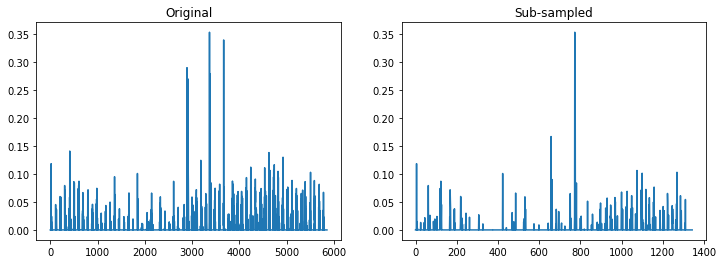

In [196]:
# As a sample
a = np.array(masterYList)
b = a[:,5]
#mapped = np.asarray(np.shape(mapped))
d = subsample_by_minmax(b, 14*24*4, True)

In [194]:
import math
from random import randint

def subsample_by_time(data, sample_size, graph=False):
    original_size = len(data)
    
    if sample_size >= original_size:  # if sample size > original size then pad with zeros
        print("You're making the data more not less here!")
        return list(np.append(data, np.zeros(sample_size - original_size)))
    
    iCounter = 0
    idx = np.array([])

    if sample_size >= original_size:  # if sample size > original size then pad with zeros
        return list(np.append(data, np.zeros(sample_size - original_size)))

    s_ratio = int(original_size//sample_size)  # sampling compression ratio
    print(type(s_ratio))
    for i in range(sample_size):
        idx = np.append(idx, data[randint(i*s_ratio, (i+1) * s_ratio)])
    
    subsample = idx

    if graph:
        plt.figure(figsize=(12,4))
        ax1 = plt.subplot(121)
        ax1.set_title("Original")
        ax1.plot(data)

        ax2 = plt.subplot(122)
        ax2.set_title("Sub-sampled")
        ax2.plot(subsample);

    return subsample

<class 'int'>


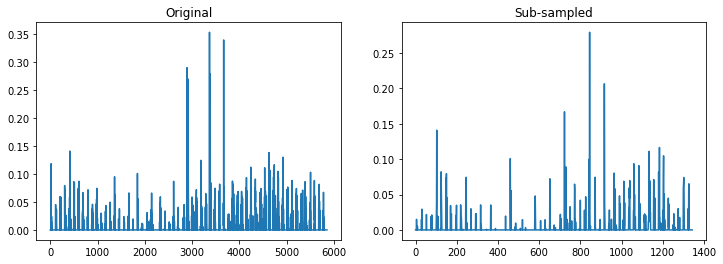

In [197]:
# As a sample
a = np.array(masterYList)
b = a[:,5]
#mapped = np.asarray(np.shape(mapped))
d = subsample_by_time(b, 14*24*4, True)

We can see that both approaches, a random sample and a time-shifted sample, does not seem to work very well in representing the original trends. As such, we shall just do a simple fit on our final dataset.

### Final fit of models

However, because LGBM and RF have a warm-start function, we can fit it repeatedly to more data and it will learn and update as it goes along.

In [42]:
#lgbm = cfg_list_lgbm[94]
lgbm

LGBMRegressor(boosting='gbdt', boosting_type='gbdt', class_weight=None,
       colsample_bytree=0.7, importance_type='split', learning_rate=0.1,
       max_depth=8, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=63,
       objective='rmse', random_state=42, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=0.7, subsample_for_bin=200000,
       subsample_freq=0, warm_start=True)

In [ ]:
for i in range (len(train_x) - 14*24*4):
    x_tr,x_tr,y_tr, y_tr = reshape_data(train_x, train_y, i, i)
    print("Fitting Fold: ", i)
    lgbm.fit(x_tr, y_tr)

Now we move on to the RF.

In [ ]:
rf = cfg_list[73]

In [55]:
for i in range (len(train_x) - 14*24*4):
    x_tr,x_tr,y_tr, y_tr = reshape_data(train_x, train_y, i, i)
    print("Fitting Fold: ", i)
    rf.fit(x_tr, y_tr)

Fitting Fold:  0
Fitting Fold:  1
Fitting Fold:  2
Fitting Fold:  3
Fitting Fold:  4
Fitting Fold:  5
Fitting Fold:  6
Fitting Fold:  7
Fitting Fold:  8
Fitting Fold:  9
Fitting Fold:  10
Fitting Fold:  11
Fitting Fold:  12
Fitting Fold:  13
Fitting Fold:  14
Fitting Fold:  15
Fitting Fold:  16
Fitting Fold:  17
Fitting Fold:  18
Fitting Fold:  19
Fitting Fold:  20
Fitting Fold:  21
Fitting Fold:  22
Fitting Fold:  23
Fitting Fold:  24
Fitting Fold:  25
Fitting Fold:  26
Fitting Fold:  27
Fitting Fold:  28
Fitting Fold:  29
Fitting Fold:  30
Fitting Fold:  31
Fitting Fold:  32
Fitting Fold:  33
Fitting Fold:  34
Fitting Fold:  35
Fitting Fold:  36
Fitting Fold:  37
Fitting Fold:  38
Fitting Fold:  39
Fitting Fold:  40
Fitting Fold:  41
Fitting Fold:  42
Fitting Fold:  43
Fitting Fold:  44
Fitting Fold:  45
Fitting Fold:  46
Fitting Fold:  47
Fitting Fold:  48
Fitting Fold:  49
Fitting Fold:  50
Fitting Fold:  51
Fitting Fold:  52
Fitting Fold:  53
Fitting Fold:  54
Fitting Fold:  55
Fi

Fitting Fold:  437
Fitting Fold:  438
Fitting Fold:  439
Fitting Fold:  440
Fitting Fold:  441
Fitting Fold:  442
Fitting Fold:  443
Fitting Fold:  444
Fitting Fold:  445
Fitting Fold:  446
Fitting Fold:  447
Fitting Fold:  448
Fitting Fold:  449
Fitting Fold:  450
Fitting Fold:  451
Fitting Fold:  452
Fitting Fold:  453
Fitting Fold:  454
Fitting Fold:  455
Fitting Fold:  456
Fitting Fold:  457
Fitting Fold:  458
Fitting Fold:  459
Fitting Fold:  460
Fitting Fold:  461
Fitting Fold:  462
Fitting Fold:  463
Fitting Fold:  464
Fitting Fold:  465
Fitting Fold:  466
Fitting Fold:  467
Fitting Fold:  468
Fitting Fold:  469
Fitting Fold:  470
Fitting Fold:  471
Fitting Fold:  472
Fitting Fold:  473
Fitting Fold:  474
Fitting Fold:  475
Fitting Fold:  476
Fitting Fold:  477
Fitting Fold:  478
Fitting Fold:  479
Fitting Fold:  480
Fitting Fold:  481
Fitting Fold:  482
Fitting Fold:  483
Fitting Fold:  484
Fitting Fold:  485
Fitting Fold:  486
Fitting Fold:  487
Fitting Fold:  488
Fitting Fold

Fitting Fold:  869
Fitting Fold:  870
Fitting Fold:  871
Fitting Fold:  872
Fitting Fold:  873
Fitting Fold:  874
Fitting Fold:  875
Fitting Fold:  876
Fitting Fold:  877
Fitting Fold:  878
Fitting Fold:  879
Fitting Fold:  880
Fitting Fold:  881
Fitting Fold:  882
Fitting Fold:  883
Fitting Fold:  884
Fitting Fold:  885
Fitting Fold:  886
Fitting Fold:  887
Fitting Fold:  888
Fitting Fold:  889
Fitting Fold:  890
Fitting Fold:  891
Fitting Fold:  892
Fitting Fold:  893
Fitting Fold:  894
Fitting Fold:  895
Fitting Fold:  896
Fitting Fold:  897
Fitting Fold:  898
Fitting Fold:  899
Fitting Fold:  900
Fitting Fold:  901
Fitting Fold:  902
Fitting Fold:  903
Fitting Fold:  904
Fitting Fold:  905
Fitting Fold:  906
Fitting Fold:  907
Fitting Fold:  908
Fitting Fold:  909
Fitting Fold:  910
Fitting Fold:  911
Fitting Fold:  912
Fitting Fold:  913
Fitting Fold:  914
Fitting Fold:  915
Fitting Fold:  916
Fitting Fold:  917
Fitting Fold:  918
Fitting Fold:  919
Fitting Fold:  920
Fitting Fold

Fitting Fold:  1286
Fitting Fold:  1287
Fitting Fold:  1288
Fitting Fold:  1289
Fitting Fold:  1290
Fitting Fold:  1291
Fitting Fold:  1292
Fitting Fold:  1293
Fitting Fold:  1294
Fitting Fold:  1295
Fitting Fold:  1296
Fitting Fold:  1297
Fitting Fold:  1298
Fitting Fold:  1299
Fitting Fold:  1300
Fitting Fold:  1301
Fitting Fold:  1302
Fitting Fold:  1303
Fitting Fold:  1304
Fitting Fold:  1305
Fitting Fold:  1306
Fitting Fold:  1307
Fitting Fold:  1308
Fitting Fold:  1309
Fitting Fold:  1310
Fitting Fold:  1311
Fitting Fold:  1312
Fitting Fold:  1313
Fitting Fold:  1314
Fitting Fold:  1315
Fitting Fold:  1316
Fitting Fold:  1317
Fitting Fold:  1318
Fitting Fold:  1319
Fitting Fold:  1320
Fitting Fold:  1321
Fitting Fold:  1322
Fitting Fold:  1323
Fitting Fold:  1324
Fitting Fold:  1325
Fitting Fold:  1326
Fitting Fold:  1327
Fitting Fold:  1328
Fitting Fold:  1329
Fitting Fold:  1330
Fitting Fold:  1331
Fitting Fold:  1332
Fitting Fold:  1333
Fitting Fold:  1334
Fitting Fold:  1335


Fitting Fold:  1696
Fitting Fold:  1697
Fitting Fold:  1698
Fitting Fold:  1699
Fitting Fold:  1700
Fitting Fold:  1701
Fitting Fold:  1702
Fitting Fold:  1703
Fitting Fold:  1704
Fitting Fold:  1705
Fitting Fold:  1706
Fitting Fold:  1707
Fitting Fold:  1708
Fitting Fold:  1709
Fitting Fold:  1710
Fitting Fold:  1711
Fitting Fold:  1712
Fitting Fold:  1713
Fitting Fold:  1714
Fitting Fold:  1715
Fitting Fold:  1716
Fitting Fold:  1717
Fitting Fold:  1718
Fitting Fold:  1719
Fitting Fold:  1720
Fitting Fold:  1721
Fitting Fold:  1722
Fitting Fold:  1723
Fitting Fold:  1724
Fitting Fold:  1725
Fitting Fold:  1726
Fitting Fold:  1727
Fitting Fold:  1728
Fitting Fold:  1729
Fitting Fold:  1730
Fitting Fold:  1731
Fitting Fold:  1732
Fitting Fold:  1733
Fitting Fold:  1734
Fitting Fold:  1735
Fitting Fold:  1736
Fitting Fold:  1737
Fitting Fold:  1738
Fitting Fold:  1739
Fitting Fold:  1740
Fitting Fold:  1741
Fitting Fold:  1742
Fitting Fold:  1743
Fitting Fold:  1744
Fitting Fold:  1745


Fitting Fold:  2106
Fitting Fold:  2107
Fitting Fold:  2108
Fitting Fold:  2109
Fitting Fold:  2110
Fitting Fold:  2111
Fitting Fold:  2112
Fitting Fold:  2113
Fitting Fold:  2114
Fitting Fold:  2115
Fitting Fold:  2116
Fitting Fold:  2117
Fitting Fold:  2118
Fitting Fold:  2119
Fitting Fold:  2120
Fitting Fold:  2121
Fitting Fold:  2122
Fitting Fold:  2123
Fitting Fold:  2124
Fitting Fold:  2125
Fitting Fold:  2126
Fitting Fold:  2127
Fitting Fold:  2128
Fitting Fold:  2129
Fitting Fold:  2130
Fitting Fold:  2131
Fitting Fold:  2132
Fitting Fold:  2133
Fitting Fold:  2134
Fitting Fold:  2135
Fitting Fold:  2136
Fitting Fold:  2137
Fitting Fold:  2138
Fitting Fold:  2139
Fitting Fold:  2140
Fitting Fold:  2141
Fitting Fold:  2142
Fitting Fold:  2143
Fitting Fold:  2144
Fitting Fold:  2145
Fitting Fold:  2146
Fitting Fold:  2147
Fitting Fold:  2148
Fitting Fold:  2149
Fitting Fold:  2150
Fitting Fold:  2151
Fitting Fold:  2152
Fitting Fold:  2153
Fitting Fold:  2154
Fitting Fold:  2155


Fitting Fold:  2516
Fitting Fold:  2517
Fitting Fold:  2518
Fitting Fold:  2519
Fitting Fold:  2520
Fitting Fold:  2521
Fitting Fold:  2522
Fitting Fold:  2523
Fitting Fold:  2524
Fitting Fold:  2525
Fitting Fold:  2526
Fitting Fold:  2527
Fitting Fold:  2528
Fitting Fold:  2529
Fitting Fold:  2530
Fitting Fold:  2531
Fitting Fold:  2532
Fitting Fold:  2533
Fitting Fold:  2534
Fitting Fold:  2535
Fitting Fold:  2536
Fitting Fold:  2537
Fitting Fold:  2538
Fitting Fold:  2539
Fitting Fold:  2540
Fitting Fold:  2541
Fitting Fold:  2542
Fitting Fold:  2543
Fitting Fold:  2544
Fitting Fold:  2545
Fitting Fold:  2546
Fitting Fold:  2547
Fitting Fold:  2548
Fitting Fold:  2549
Fitting Fold:  2550
Fitting Fold:  2551
Fitting Fold:  2552
Fitting Fold:  2553
Fitting Fold:  2554
Fitting Fold:  2555
Fitting Fold:  2556
Fitting Fold:  2557
Fitting Fold:  2558
Fitting Fold:  2559
Fitting Fold:  2560
Fitting Fold:  2561
Fitting Fold:  2562
Fitting Fold:  2563
Fitting Fold:  2564
Fitting Fold:  2565


Fitting Fold:  2926
Fitting Fold:  2927
Fitting Fold:  2928
Fitting Fold:  2929
Fitting Fold:  2930
Fitting Fold:  2931
Fitting Fold:  2932
Fitting Fold:  2933
Fitting Fold:  2934
Fitting Fold:  2935
Fitting Fold:  2936
Fitting Fold:  2937
Fitting Fold:  2938
Fitting Fold:  2939
Fitting Fold:  2940
Fitting Fold:  2941
Fitting Fold:  2942
Fitting Fold:  2943
Fitting Fold:  2944
Fitting Fold:  2945
Fitting Fold:  2946
Fitting Fold:  2947
Fitting Fold:  2948
Fitting Fold:  2949
Fitting Fold:  2950
Fitting Fold:  2951
Fitting Fold:  2952
Fitting Fold:  2953
Fitting Fold:  2954
Fitting Fold:  2955
Fitting Fold:  2956
Fitting Fold:  2957
Fitting Fold:  2958
Fitting Fold:  2959
Fitting Fold:  2960
Fitting Fold:  2961
Fitting Fold:  2962
Fitting Fold:  2963
Fitting Fold:  2964
Fitting Fold:  2965
Fitting Fold:  2966
Fitting Fold:  2967
Fitting Fold:  2968
Fitting Fold:  2969
Fitting Fold:  2970
Fitting Fold:  2971
Fitting Fold:  2972
Fitting Fold:  2973
Fitting Fold:  2974
Fitting Fold:  2975


In [56]:
def testModels(model, X, y):
    sizeTest = 3
    all_valid_RMSE = []
    all_valid_r2 = []
    for j in range(sizeTest):
        # x_train = x_test, y_train = y_test
        x_train, x_test, y_train, y_test = reshape_data(X, y, j, j)
        
        # Next, to compute mean statistics
        # train and valid statistics are the same here
        train_rmse, train_r2, valid_rmse, valid_r2 = report_results(model, x_train, y_train, x_test, y_test)

        all_valid_RMSE.append(valid_rmse)
        all_valid_r2.append(valid_r2)

    all_valid_RMSE = np.array(all_valid_RMSE)
    all_valid_r2 = np.array(all_valid_r2)

    print("For Model: ", model)
    print("Mean Test RMSE: {:0.4f}".format(np.mean(all_valid_RMSE)))
    print("Max Test RMSE: {:0.4f}".format(np.max(all_valid_RMSE)))
    print("Min Test RMSE: {:0.4f}".format(np.min(all_valid_RMSE)))
    print("Mean Test R2 score: {:0.4f}".format(np.mean(all_valid_r2)))
    print("Max Test R2 score: {:0.4f}".format(np.max(all_valid_r2)))
    print("Min Test R2 score: {:0.4f}".format(np.min(all_valid_r2)))
    print("========================================================================")

svr = cfg_list_svr[5]


In [57]:
testModels(lgbm, test_x, test_y)

Train RMSE: 0.0795 ... Valid RMSE: 0.0795
Train R2 score: 0.6871 ... Valid R2 score: 0.6871
Train RMSE: 0.1499 ... Valid RMSE: 0.1499
Train R2 score: -11.2553 ... Valid R2 score: -11.2553
Train RMSE: 0.1526 ... Valid RMSE: 0.1526
Train R2 score: -12.0909 ... Valid R2 score: -12.0909
For Model:  LGBMRegressor(boosting='gbdt', boosting_type='gbdt', class_weight=None,
       colsample_bytree=0.7, importance_type='split', learning_rate=0.1,
       max_depth=8, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=63,
       objective='rmse', random_state=42, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=0.7, subsample_for_bin=200000,
       subsample_freq=0, warm_start=True)
Mean Test RMSE: 0.1273
Max Test RMSE: 0.1526
Min Test RMSE: 0.0795
Mean Test R2 score: -7.5530
Max Test R2 score: 0.6871
Min Test R2 score: -12.0909


In [58]:
i = np.random.randint
x_tr,x_tr,y_tr, y_tr = reshape_data(train_x, train_y, 5, 5)
print("Fitting Fold: ", i)
svr.fit(x_tr, y_tr)    

testModels(rf, test_x, test_y)
testModels(svr, test_x, test_y)

Fitting Fold:  <built-in method randint of mtrand.RandomState object at 0x112bc9e58>
Train RMSE: 0.1303 ... Valid RMSE: 0.1303
Train R2 score: 0.1589 ... Valid R2 score: 0.1589
Train RMSE: 0.0261 ... Valid RMSE: 0.0261
Train R2 score: 0.6280 ... Valid R2 score: 0.6280
Train RMSE: 0.0275 ... Valid RMSE: 0.0275
Train R2 score: 0.5766 ... Valid R2 score: 0.5766
For Model:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=100, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
Mean Test RMSE: 0.0613
Max Test RMSE: 0.1303
Min Test RMSE: 0.0261
Mean Test R2 score: 0.4545
Max Test R2 score: 0.6280
Min Test R2 score: 0.1589
Train RMSE: 0.0878 ... Valid RMSE: 0.0878
Train R2 score: 0.6188 ... Valid R2 score: 0.6188
Train R

Conclusions:
    - The LGBM looks like it overfitted.
    - The RF did very poorly on fold 1, so it might have overfit abit. 
    - SVR did poorly too

### Saving our model

We have found our best model, with a RMSE of 0.0613 on our test set. 

For perspective:

![title](img/AutoML_accuracy.png)


This was the AutoML performance with the untouched data + a random CV (not taking into account time-series nature). This is the score to beat for any model.

In [59]:
import pickle
# save model to file
pickle.dump(rf, open("bestModel.pickle.dat", "wb"))

## Possible Questions You May Have

1. Why did you index the train and test data with a geohash? 
    - I did it mainly to fit the eventual test data which is unseen, except for Geohash.
    - We assumed independent and identically distributed observations. Based on the Geohash sizes we see below, GeoHash6 actually has a large area of 1.2km by 600m. An average Grab user should not be moving into another Geohash just to tap on cheaper demand prices. Therefore, demand observations (if only influenced by user booking) should be i.i.d
    
![title](img/GeoHashSize.png)

   
   - There are however, also reasons to believe it is not i.i.d though (i.e., observations that are “nearer” to each other should be more similar), especially if demand is defined in relation with supply (i.e drivers can roam freely to meet demand). This is also true when we consider the Bokeh plot and see that nearer areas have similar demand values. 

2. Why use zero imputation instead of other forms of imputations?
Possible solutions:
    1. Statistical imputation (mean, median, 0 etc)
    2. Supervised imputation (using ML to impute based on historical data)
        
        
Back to 1st principles: Why do we have null values?

Possible reasons:
    1. No bookings were made in that time period. Therefore if there was a booking, there should be a demand value. This demand value is latent simply because no one booked
    2. Null actually corresponds to 0 demand. Indeed when we find the minimum demand possible, it was not 0 but a value very close to 0. Therefore, putting it at 0 demand sounds logical.


## Assumptions in Model

1. Assume demand is normalised after seeing both train and test data-set.
2. Assume stationary data, though it may not be so as we can see through simple visualisation across days (mean and variance are different). A Dickey-Fuller test can confirm this through statistical means. If proven so, more transformation is needed to handle such non-stationary data
3. Assume ML model captures geo-data that was lost via indexing rather than as a feature through multiple fits
4. Assume ML model captures time sensitivity: can be mapped by showing the splits of the RF

In this notebook, our sole purpose is to 
    1) find the appropriate way to organise our information
    2) test which models work best given this data structure
    3) save that test model

### Things to Improve on

1. Data Cleaning
    - I forgot that I dropped Day 24 in the train set, so some folds in the sliding window have 0 values that may impact the accuracy of the model.
        - I should have slided over those windows that had the data, or gave a week seperation from Day 24
    - Finding outliers and dropping them or using replacement data --> can use machine learning model to do this and drop the features that are outliers e.g. Grubbs Test: https://blog.statsbot.co/time-series-anomaly-detection-algorithms-1cef5519aef2. This should be done on the eventual test set too

2. Feature Engineering
    - Is there a better way to arrange our data such that we do not lose our latitude and longitude values? By forcing the Geohash as index, it was seemingly impossible to fit in latitude and logitude as features.

3. Model Selection
    - Try RNN with LSTMs!
    - Learn about statistical approaches to time-series

4. Model Hyper-parameter Tuning
    - Could have a lower bound for predicted values in our array e.g. if predict < 0.001, predict = 0. When we look at our y-predict, all of them have a value > 0, and the errors may propogate this way through the RMSE method.


### Possible Extensions

1. Detect Anomalies. E.g. ping user if there's anomaly today (e.g. exogenous factors) such that widget is no longer useful: https://blog.statsbot.co/time-series-anomaly-detection-algorithms-1cef5519aef2
2. Automated Testing
3. Predict a range with confidence, then report the highest bounds for the user
4. Cluster into segments, then plot average demand in each segment for other purposes e.g. visualisation for Grab Team
5. Plot out graphs of predicted vs actual through Bokeh (like we did in the last cell of EDA) to visualise how our model fares